# 🔵 Problem Statement
Common techniques used to make non-stationary series stationary, like $d$ order difference make series loose memory.
- This means that, while you're making your series stationary, you're loosing most of the information/memory contained in the series

The idea is then to apply a transformation, that still makes a series stationary, but loses the least amount of memory possible.

# 🔵 Fractional Difference
We'll use a non-integer difference, in order to preserve some memory. 

Backshift operator
$$
    B^kX_t = X_{t-k}
$$
- Works just like a operator in quantum mechanics 




## 🔷 Series representation and Weights
$$
    \tilde{X}_t = \sum_{k=0}^\infty \omega_k X_{t-k}
$$
where the weights $\omega$ are calculated as:
$$
    \omega = \Big\{1, -d, \frac{d(d-1)}{2!}, \frac{d(d-1)(d-2)}{3!}, \dots, (-1)^k\prod_{i=0}^{k-1}\frac{d-i}{k!}, \dots\Big\}
$$

Iteratively, we can calculate $\omega$ as
$$
    \omega_k = \omega_{k-1} \frac{d-k+1}{k}
$$

- Notice that for integer $d$, every weight is zero for $k \geq d - 1$.

⭐ Note that the magnitude of weights decrease (sometimes asymptotically) with time.
- Recent points have greater weight than older ones


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
import plotly.graph_objects as go

In [2]:
def getWeights(d, size, break_zero=False):
    """
        d: Degree of differentation (integer or float)
        size: Max iteration - summation to infinity
    """

    w=[1.]

    for k in range(1, size):
        w_ = -w[-1]*(d-k+1)/k
        w.append(w_)

        if break_zero and w_ == 0:
            break
    
    return np.array(w[::-1]).reshape(-1, 1)


def plotWeights(dRange, nPlots, size):
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_ = getWeights(d, size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')

    sns.lineplot(w)

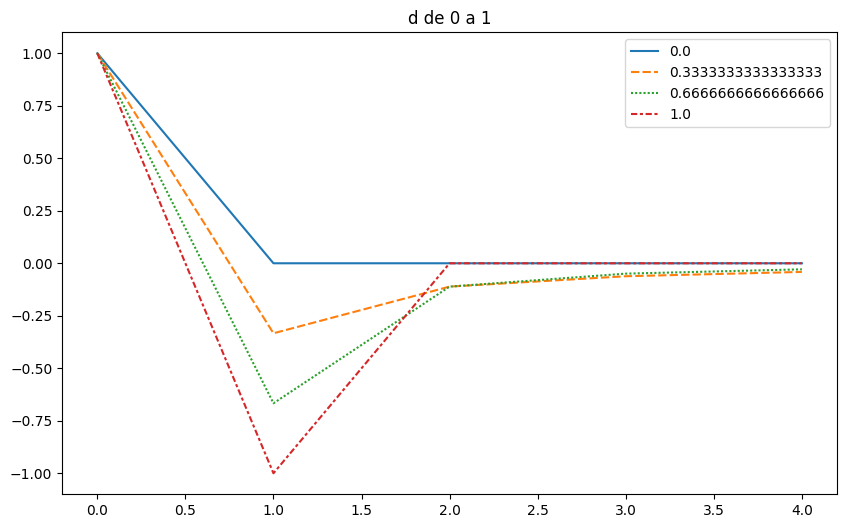

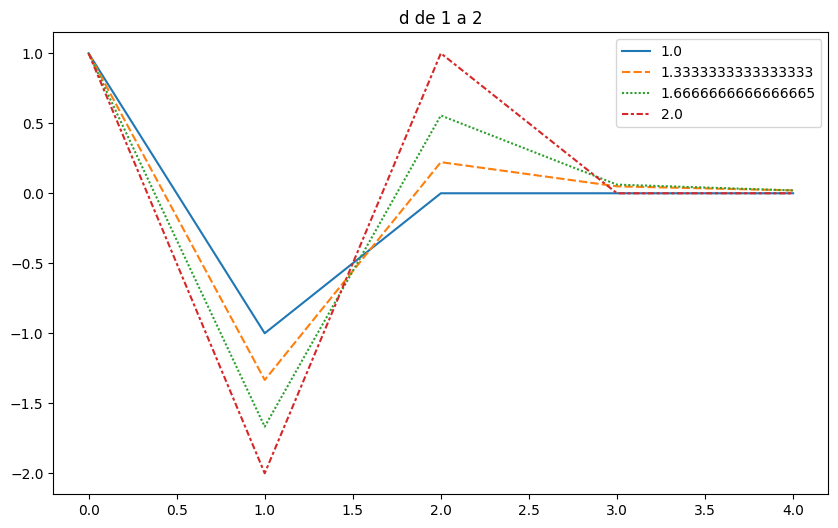

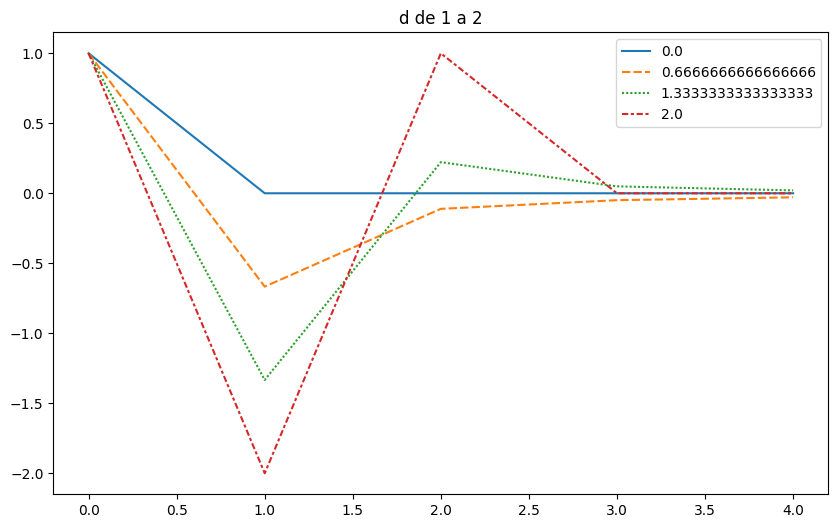

In [3]:
plt.figure(figsize=(10, 6))
plotWeights([0, 1], 4, 5)
plt.title("d de 0 a 1")
plt.show()

plt.figure(figsize=(10, 6))
plt.title("d de 1 a 2")
plotWeights([1, 2], 4, 5)

plt.figure(figsize=(10, 6))
plt.title("d de 1 a 2")
plotWeights([0, 2], 4, 5)


## 🔷 Fractional Difference


### 🔹Weight Loss
A problem present in fracional difference implementations, is that of **weight loss**. Consider a differentiated time series at $\tilde{X}_T$, up to that point it has used weights up to

$$
    \omega_k \;\;, k=0, \dots, T-1
$$

And for a previous point $\tilde{X}_{T-l}$, it'd use 

$$
    \omega_{k-l}\;\;, k=0, \dots, T-l-1.
$$

This happens because of data limitations, since t calculate $T$ you need $T-1$, and the weights go you that.

For example,
$$
    \tilde{X}_5 = 1*X_0 - d*X_1 + \frac{d(d-1)}{2!}X_2 - \frac{d(d-1)(d-2)}{3!}X_3 + \frac{d(d-1)(d-2)(d-3)}{4!}X_4
$$

And for a lower value, we'd get

$$
    \tilde{X}_3 = 1*X_0 - d*X_1 + \frac{d(d-1)}{2!}X_2 
$$

This difference gives rise to the so-called **weight loss**. Meaning that, earlier points have less access to memory than later points, since the differentiation goes up to that index.
- Different point use different amounts of memory

Earlier points ignore historical memory, and some of them might be unuseable for that reason. They have to little memory to accurately represent the data

### 🔹Measuring Weight-Loss

Given a point $l$, we calculate it's weight loss as:
$$
    \lambda_l = \frac{\sum_{j=T-l}^T|\omega_j|}{\sum_{i=0}^T|\omega_i|}
$$
- Summation of the weights up to where you calcuating, over the whole weights in the set.
- It measures / represents weight loss (weights not considered)

The less the value of $\lambda$ the better.

### 🔹Tolerance
We then define a tolerance value $\tau \in [0,1]$, representing the maximum weight-loss acceptable.
- We choose a value of $\tau$, such that every point that has weight-loss greater than that value is disconsidered.

Mathematically, we determine the value $l^*$ that represents the first index where the weight-loss excedess the threashold.
- Every point before $l^*$ is considered too innacurate to use
- $\lambda_{l^*} \leq \tau$ and $\lambda_{l^*+1} > \tau$

In [4]:
def plot_weight_loss(d, size):
    w=[1.]

    for k in range(1, size):
        w_ = -w[-1]*(d-k+1)/k
        w.append(w_)

    w_total = np.sum(np.abs(w))

    w_loss = []
    for k in range(len(w)):
        w_loss_ = np.sum(np.abs(w[k:]))/w_total
        w_loss.append(w_loss_)

    # sns.lineplot(x=[k for k in range(len(w))], y=w_loss)

    return w_loss

In [5]:
fig = go.Figure()

d_values = [0.3, 1, 3.7, 6.5, 8, 33.2]
tolerance = 0.01

size = 40

for d in d_values:
    w_loss = plot_weight_loss(d, size)

    fig.add_trace(go.Scatter(x=[k for k in range(len(w_loss))], y=w_loss, name=f"d={d}"))

fig.add_shape(
    type="line",
    x0=0, x1=size,  # x-coordinate of the vertical line
    y0=tolerance, y1=tolerance,  # y-coordinate range of the line
    line=dict(color="Red", width=2, dash="dot"),  # Line style
)

fig.update_layout(
    title="Weight Loss",
    width=1200,
    height=800,
    yaxis_type="log"
)



## 🔷 Expanding Window Implementation

The first alternative to deal with weight loss. You calculate the weight loss from $\lambda$ and then use the tolerance to find $l^*$. With that, you have the method of expanding window.

In [6]:
def fracDiff(series, d, thres = .01):
    """
    Increasing width window, with treatment of NaNs (Standard Fracdiff, expanding window)
    Note 1: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    """
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0]) # each obs has a weight
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w)) # cumulative weights
    w_ /= w_[-1] # determine the relative weight-loss
    skip = w_[w_ > thres].shape[0]  # the no. of results where the weight-loss is beyond the acceptable value
    #3) Apply weights to values
    df = {} # empty dictionary
    for name in series.columns:
        # fill the na prices
        seriesF = series[[name]].ffill().dropna()
        df_ = pd.Series() # create a pd series
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc] # find the iloc th obs 
            
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            
            if not np.isfinite(test_val).any():
                 continue # exclude NAs
            try: # the (iloc)^th obs will use all the weights from the start to the (iloc)^th
                df_.loc[loc]=np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name] = df_.copy(deep = True)
    df = pd.concat(df, axis = 1)
    return df

In [7]:
corn = yf.download("ZC=F", start="2020-01-01", end="2023-12-31", interval="1d")
corn.columns = corn.columns.get_level_values(0)
corn

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-02,391.50,391.50,392.00,387.25,387.75,103987
2020-01-03,386.50,386.50,392.00,385.50,391.50,125931
2020-01-06,384.75,384.75,387.75,382.75,386.25,112130
2020-01-07,384.50,384.50,385.75,383.50,385.00,93541
2020-01-08,384.25,384.25,385.50,382.25,384.00,135523
...,...,...,...,...,...,...
2023-12-22,473.00,473.00,474.00,471.50,472.50,80484
2023-12-26,480.25,480.25,481.00,471.50,473.00,114198
2023-12-27,476.50,476.50,480.25,474.50,479.75,107950


Text(0.5, 1.0, 'd=1')

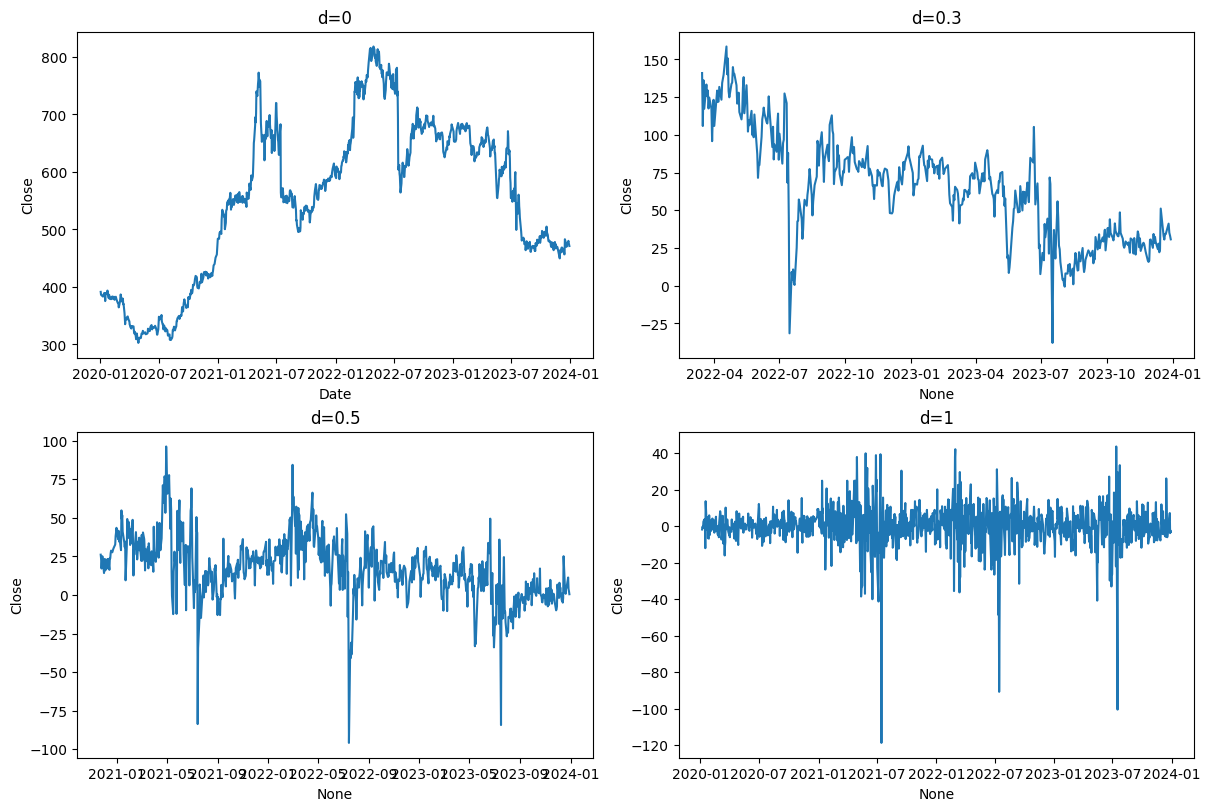

In [8]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 8))

axs = axs.flatten()

# corn_frac = fracDiff_FFD(corn, 0, thres=0.01)
sns.lineplot(corn, x=corn.index, y="Close", ax=axs[0])
axs[0].set_title("d=0")

corn_frac = fracDiff(corn, 0.3, thres=0.01)
sns.lineplot(corn_frac, x=corn_frac.index, y="Close", ax=axs[1])
axs[1].set_title("d=0.3")


corn_frac = fracDiff(corn, 0.5, thres=0.01)
sns.lineplot(corn_frac, x=corn_frac.index, y="Close", ax=axs[2])
axs[2].set_title("d=0.5")

corn_frac = fracDiff(corn, 1, thres=0.01)
sns.lineplot(corn_frac, x=corn_frac.index, y="Close", ax=axs[3])
axs[3].set_title("d=1")

❗We notice a downward trend, caused by the negative values in the weights

## 🔷 Fixed Window Implementation

This is the second alternative, that tries to address the problem of negative drift. Insteand of an expading window, we'll use a fixed-width window to compute the fractional difference.

Instead of looking to the weight loss, that implies changing width, we'll use the actual value of the weights to define a window. We'll find the first $l^*$ such that $|\omega_{l^*}| \geq \tau$ and $|\omega_{l^* + 1}| \leq \tau$. 

This will imply the creating of a "new" weight variable:
$$
    \tilde{\omega}_k = \begin{cases}\omega_k\hspace{5mm} if\: k \leq l^* \\ 0 \hspace{8mm} if \: k > l^*\end{cases}
$$

The series is then expressed as 
$$
    \tilde{X}_t = \sum_{k=0}^{l^*} \tilde{\omega}_k X_{t-k} \hspace{10mm} \text{for} \; t= T - l^* + 1, \dots, T.
$$


In [9]:
def getWeights_FFD(d, thres):
    # Fixed Frac Diff
    # thres>0 drops insignificant weights
    w = [1.]
    k = 1
    while abs(w[-1]) >= thres:  
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
        k += 1
    w = np.array(w[ : : -1]).reshape(-1, 1)[1 : ]  
    return w

def fracDiff_FFD(series, d, thres = 1e-5):
    """
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    """
    #1) Compute weights for the longest series
    w = getWeights_FFD(d, thres)
    # w = getWeights(d, series.shape[0])
    #w=getWeights_FFD(d,thres)
    width = len(w) - 1
    #2) Apply weights to values
    df = {} # empty dict
    for name in series.columns:
        seriesF = series[[name]].ffill().dropna()
        df_ = pd.Series() # empty pd.series
        for iloc1 in range(width, seriesF.shape[0]):
            loc0 = seriesF.index[iloc1 - width]
            loc1 = seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1,name]):
                continue # exclude NAs
            #try: # the (iloc)^th obs will use all the weights from the start to the (iloc)^th
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0 : loc1])[0, 0]
            # except:
            #     continue
            
        df[name] = df_.copy(deep = True)
    df = pd.concat(df, axis = 1)
    return df

Text(0.5, 1.0, 'd=1')

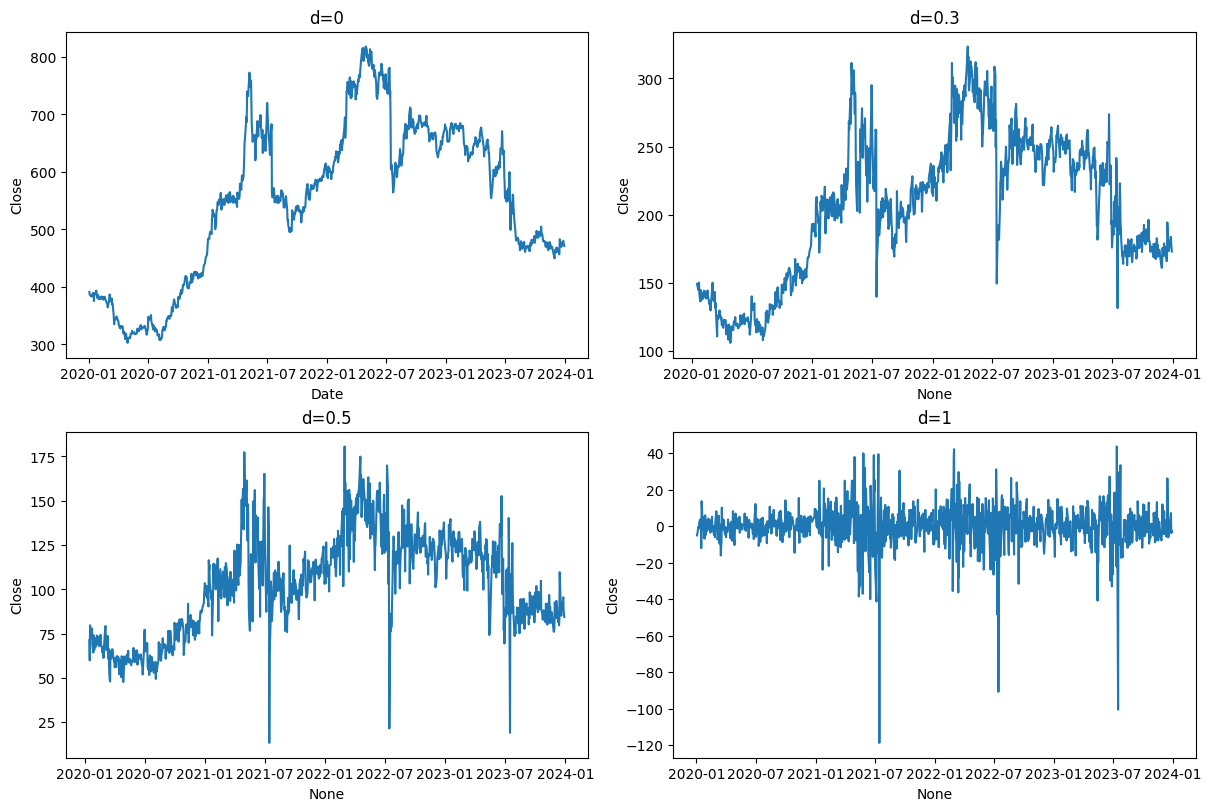

In [10]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 8))

axs = axs.flatten()

# corn_frac = fracDiff_FFD(corn, 0, thres=0.01)
sns.lineplot(corn, x=corn.index, y="Close", ax=axs[0])
axs[0].set_title("d=0")

corn_frac = fracDiff_FFD(corn, 0.3, thres=0.01)
sns.lineplot(corn_frac, x=corn_frac.index, y="Close", ax=axs[1])
axs[1].set_title("d=0.3")


corn_frac = fracDiff_FFD(corn, 0.5, thres=0.01)
sns.lineplot(corn_frac, x=corn_frac.index, y="Close", ax=axs[2])
axs[2].set_title("d=0.5")

corn_frac = fracDiff_FFD(corn, 1, thres=0.01)
sns.lineplot(corn_frac, x=corn_frac.index, y="Close", ax=axs[3])
axs[3].set_title("d=1")

⭐ No Negative Drift

## 🔷 Maximum Memory Preservation - Minimum Difference

1. We'll calculate the fractional difference algorithm for different values of $d$ from lower to higher. 
2. We will choose the firt value of $d$ that gives a stationary series according to some statistical metric (e.g. adfuller)

We also show the correlation of the original series with the difference one, in a way to understand how much information we've lost in the differenced series, compared to the original one.

In [11]:
def plotMinFFD(instName):
    from statsmodels.tsa.stattools import adfuller

    if isinstance(instName, pd.DataFrame):
        instName.to_csv("temp_df.csv")
        instName = "temp_df"

    path = ''
    out = pd.DataFrame(columns= ['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    df0 = pd.read_csv(path + instName +'.csv',index_col = 0, parse_dates = True)
    for d in np.linspace(0, 1, 11):
        df1 = np.log(df0[['Close']]).resample('1D').last() # downcast to daily obs
        df2 = fracDiff_FFD(df1, d, thres = .01)
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0, 1]
        df2 = adfuller(df2['Close'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[ : 4]) + [df2[4]['5%']] + [corr] # with critical value
    out.to_csv(path + instName + '_testMinFFD.csv')
    out[['adfStat', 'corr']].plot(secondary_y = 'adfStat')
    plt.axhline(out['95% conf'].mean(), linewidth = 1, color = 'r', linestyle = 'dotted')
    # plt.savefig(path + instName + '_testMinFFD.png')
    return

def plotMinMFD(instName):
    from statsmodels.tsa.stattools import adfuller

    if isinstance(instName, pd.DataFrame):
        instName.to_csv("temp_df.csv")
        instName = "temp_df"

    path = ''
    out = pd.DataFrame(columns= ['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    df0 = pd.read_csv(path + instName +'.csv',index_col = 0, parse_dates = True)
    for d in np.linspace(0, 1, 11):
        df1 = np.log(df0[['Close']]).resample('1D').last() # downcast to daily obs
        df2 = fracDiff(df1, d, thres = .01)
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0, 1]
        df2 = adfuller(df2['Close'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[ : 4]) + [df2[4]['5%']] + [corr] # with critical value
    out.to_csv(path + instName + '_testMinFFD.csv')
    out[['adfStat', 'corr']].plot(secondary_y = 'adfStat')
    plt.axhline(out['95% conf'].mean(), linewidth = 1, color = 'r', linestyle = 'dotted')
    # plt.savefig(path + instName + '_testMinFFD.png')
    return

def optimal_mfd(data, start = 0, end = 1, interval = 10, t=0.01, column="price"):
    
    for d in np.linspace(start, end, interval):    
        dfx = fracDiff(data.to_frame(), d, thres = t)
        if sm.tsa.stattools.adfuller(dfx[column], maxlag=1,regression='c',autolag=None)[1] < 0.05:
            return d
    print('no optimal d')
    return d

def optimal_ffd(data, start = 0, end = 1, interval = 10, t=1e-5, column="price"):
    
    for d in np.linspace(start, end, interval):    
        dfx = fracDiff_FFD(data.to_frame(), d, thres = t)
        if sm.tsa.stattools.adfuller(dfx[column], maxlag=1,regression='c',autolag=None)[1] < 0.05:
            return d
    print('no optimal d')
    return d

np.float64(0.3333333333333333)

<Figure size 1000x600 with 0 Axes>

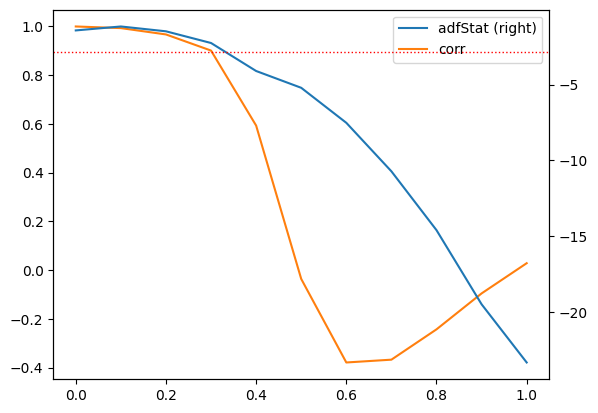

In [12]:
plt.figure(figsize=(10, 6))

plotMinMFD(corn)
optimal_mfd(corn["Close"], column="Close", t=1e-2)

np.float64(0.3333333333333333)

<Figure size 1000x600 with 0 Axes>

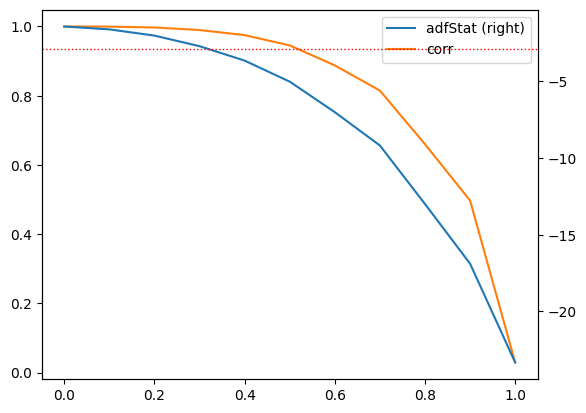

In [13]:
plt.figure(figsize=(10, 6))

plotMinFFD(corn)
optimal_ffd(corn["Close"], column="Close", t=1e-4)

### 🔹Aplying Minimum Difference

In [14]:
corn.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1006, freq=None)

Text(0.5, 1.0, 'FFD - d=0.3')

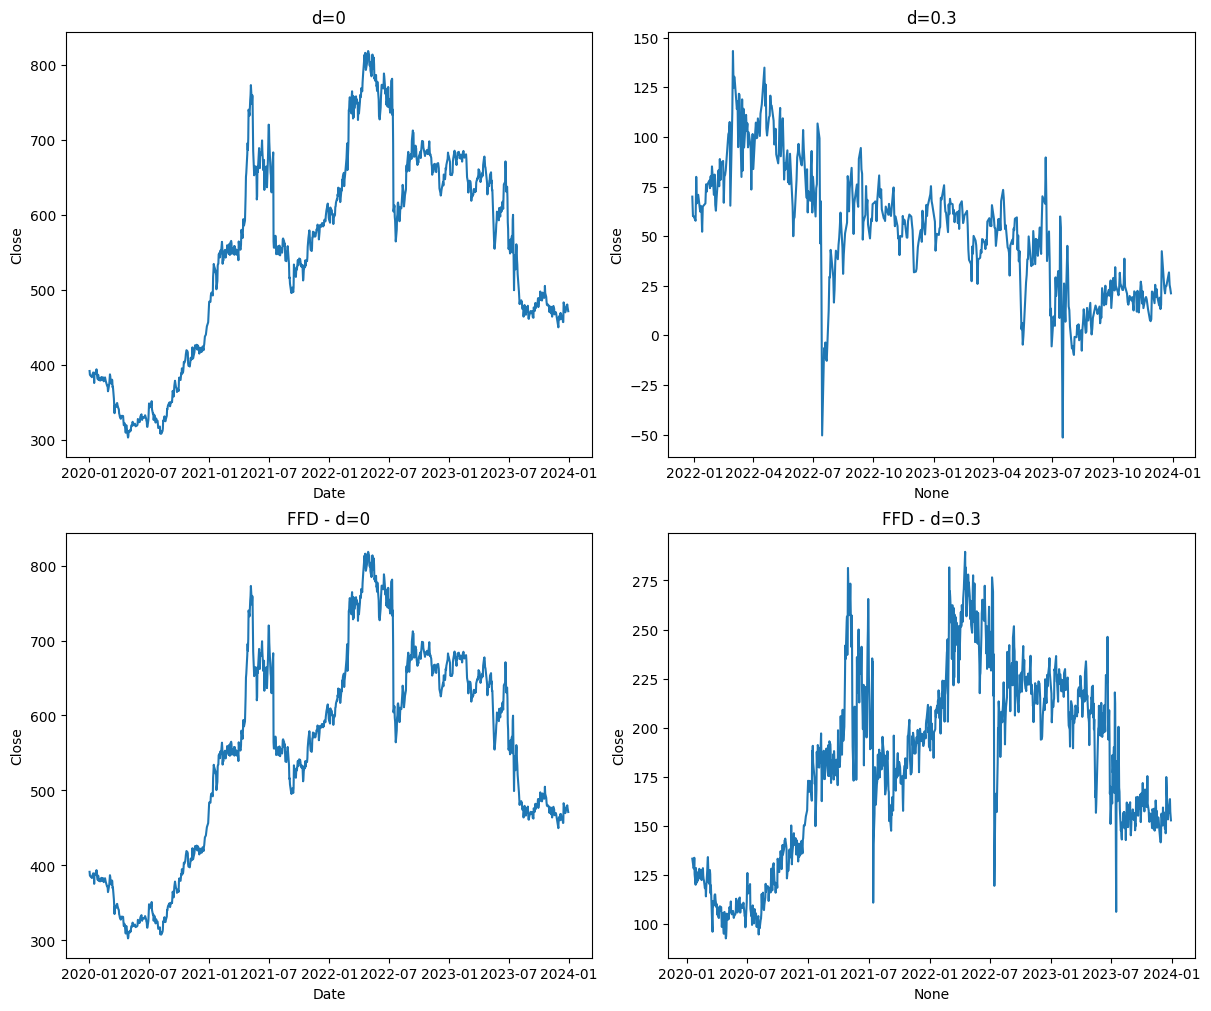

In [15]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(12, 10))

axs = axs.flatten()

# corn_frac = fracDiff_FFD(corn, 1/3, thres=0.01)
sns.lineplot(corn, x=corn.index, y="Close", ax=axs[0])
axs[0].set_title("d=0")

corn_frac = fracDiff(corn, 1/3, thres=0.01)
sns.lineplot(corn_frac, x=corn_frac.index, y="Close", ax=axs[1])
axs[1].set_title("d=0.3")

# corn_frac = fracDiff_FFD(corn, 1/3, thres=0.01)
sns.lineplot(corn, x=corn.index, y="Close", ax=axs[2])
axs[2].set_title("FFD - d=0")

corn_frac = fracDiff_FFD(corn, 1/3, thres=0.01)
sns.lineplot(corn_frac, x=corn_frac.index, y="Close", ax=axs[3])
axs[3].set_title("FFD - d=0.3")